In [1]:
! pip install torchinfo

In [2]:
# Codeblock 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader

In [3]:
# Codeblock 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Codeblock 3
def load_images(path):

    images = []
    filenames = os.listdir(path)
    
    for filename in tqdm(filenames): 
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    
    return np.array(images)

In [5]:
# Codeblock 4
cats_train = load_images('/kaggle/input/cat-and-dog/training_set/training_set/cats')
dogs_train = load_images('/kaggle/input/cat-and-dog/training_set/training_set/dogs')

cats_test = load_images('/kaggle/input/cat-and-dog/test_set/test_set/cats')
dogs_test = load_images('/kaggle/input/cat-and-dog/test_set/test_set/dogs')

100%|██████████| 1013/1013 [00:07<00:00, 141.02it/s]


In [6]:
# Codeblock 5
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(4000, 100, 100, 3)
(4005, 100, 100, 3)
(1011, 100, 100, 3)
(1012, 100, 100, 3)


In [7]:
# Codeblock 6
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(8005, 100, 100, 3)
(2023, 100, 100, 3)


In [8]:
# Codeblock 7
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(8005,)
(2023,)


In [9]:
# Codeblock 8
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

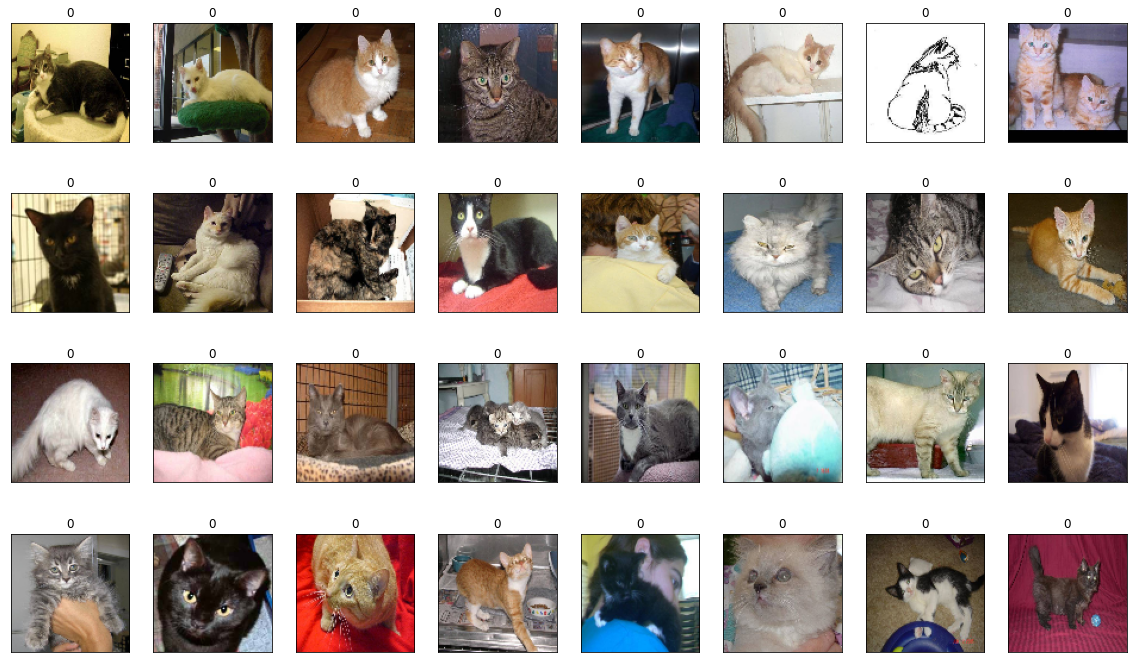

In [10]:
# Codeblock 9
show_images(X_train, y_train, 0)

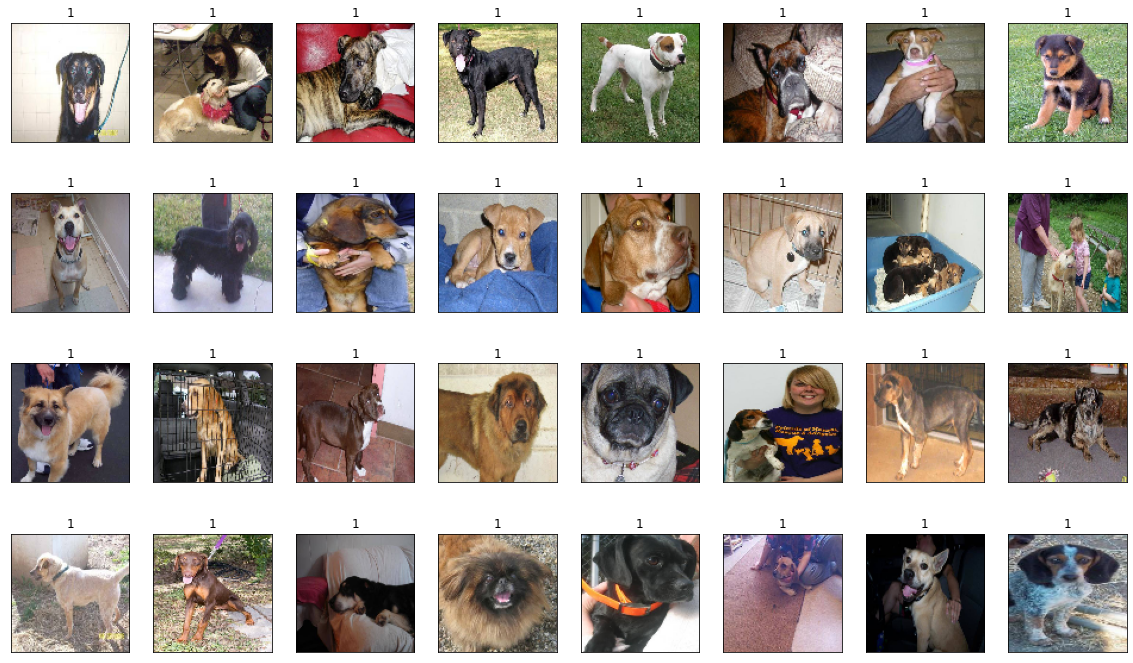

In [11]:
# Codeblock 10
show_images(X_train, y_train, 4000)

In [12]:
# Codeblock 11
print(y_train[:10])

[0 0 0 0 0 0 0 0 0 0]


In [13]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [14]:
# Codeblock 13
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20), 
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.RandomVerticalFlip(p=0.005), 
                                       transforms.RandomGrayscale(p=0.2), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [15]:
# Codeblock 14
transforms_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [16]:
# Codeblock 15
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [17]:
# Codeblock 16
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [18]:
# Codeblock 17
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [19]:
# Codeblock 18
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


torch.Size([32, 100, 100, 3])


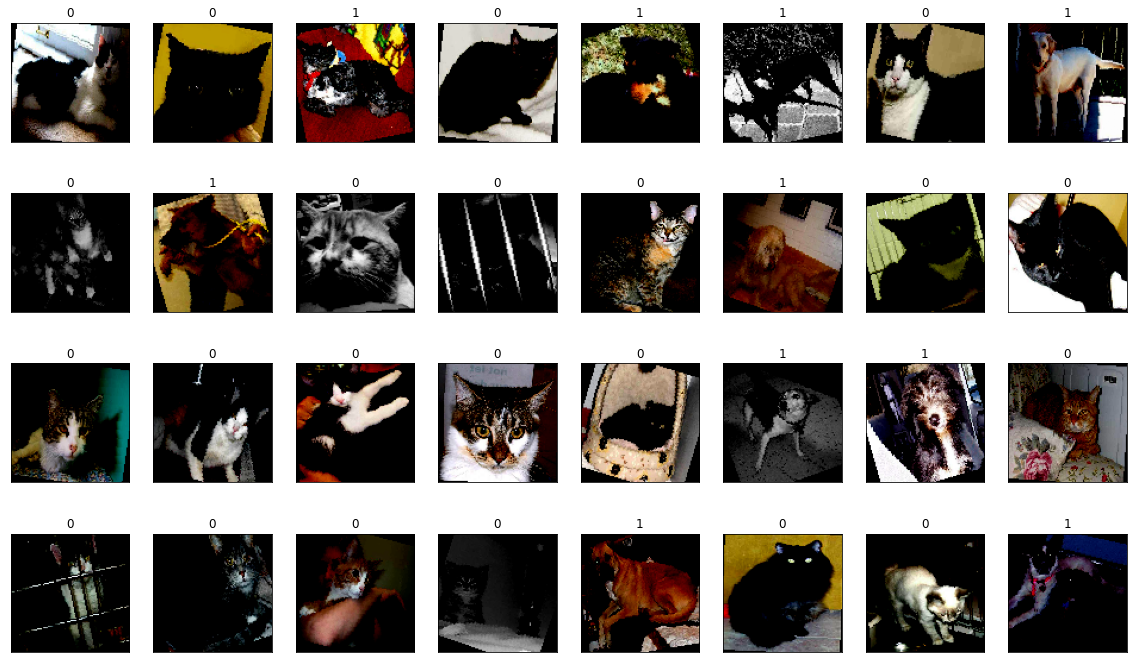

In [20]:
# Codeblock 19
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

In [21]:
# Codeblock 20
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # self.maxpool
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # self.maxpool
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # self.maxpool
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128*6*6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        return x

In [22]:
# Codeblock 21
model = CNN().to(device)

In [23]:
# Codeblock 22
summary(model, input_size=(4,3,100,100))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [4, 1]                    --
├─Conv2d: 1-1                            [4, 16, 100, 100]         432
├─BatchNorm2d: 1-2                       [4, 16, 100, 100]         32
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           --
├─Conv2d: 1-4                            [4, 32, 50, 50]           4,608
├─BatchNorm2d: 1-5                       [4, 32, 50, 50]           64
├─MaxPool2d: 1-6                         [4, 32, 25, 25]           --
├─Conv2d: 1-7                            [4, 64, 25, 25]           18,432
├─BatchNorm2d: 1-8                       [4, 64, 25, 25]           128
├─MaxPool2d: 1-9                         [4, 64, 12, 12]           --
├─Conv2d: 1-10                           [4, 128, 12, 12]          73,728
├─BatchNorm2d: 1-11                      [4, 128, 12, 12]          256
├─MaxPool2d: 1-12                        [4, 128, 6, 6]            --
├

In [24]:
# Codeblock 23
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Codeblock 24
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [26]:
# Codeblock 25

train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []

for epoch in range(100):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)
        
        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)
            
        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 250/250 [00:11<00:00, 22.21it/s]


Epoch: 0 	| Train loss: 0.49 	| Test loss: 0.696 	| Train acc: 0.66 	| Test acc: 0.71


100%|██████████| 250/250 [00:10<00:00, 24.02it/s]


Epoch: 1 	| Train loss: 0.545 	| Test loss: 0.473 	| Train acc: 0.73 	| Test acc: 0.77


100%|██████████| 250/250 [00:10<00:00, 22.96it/s]


Epoch: 2 	| Train loss: 0.469 	| Test loss: 0.45 	| Train acc: 0.76 	| Test acc: 0.78


100%|██████████| 250/250 [00:10<00:00, 22.74it/s]


Epoch: 3 	| Train loss: 0.342 	| Test loss: 0.425 	| Train acc: 0.79 	| Test acc: 0.81


100%|██████████| 250/250 [00:10<00:00, 23.80it/s]


Epoch: 4 	| Train loss: 0.356 	| Test loss: 0.36 	| Train acc: 0.8 	| Test acc: 0.81


100%|██████████| 250/250 [00:10<00:00, 23.14it/s]


Epoch: 5 	| Train loss: 0.363 	| Test loss: 0.375 	| Train acc: 0.81 	| Test acc: 0.8


100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Epoch: 6 	| Train loss: 0.485 	| Test loss: 0.307 	| Train acc: 0.83 	| Test acc: 0.86


100%|██████████| 250/250 [00:10<00:00, 22.79it/s]


Epoch: 7 	| Train loss: 0.414 	| Test loss: 0.249 	| Train acc: 0.84 	| Test acc: 0.85


100%|██████████| 250/250 [00:10<00:00, 23.29it/s]


Epoch: 8 	| Train loss: 0.432 	| Test loss: 0.411 	| Train acc: 0.84 	| Test acc: 0.81


100%|██████████| 250/250 [00:11<00:00, 22.15it/s]


Epoch: 9 	| Train loss: 0.411 	| Test loss: 0.55 	| Train acc: 0.85 	| Test acc: 0.78


100%|██████████| 250/250 [00:10<00:00, 23.05it/s]


Epoch: 10 	| Train loss: 0.389 	| Test loss: 0.458 	| Train acc: 0.86 	| Test acc: 0.83


100%|██████████| 250/250 [00:11<00:00, 22.24it/s]


Epoch: 11 	| Train loss: 0.226 	| Test loss: 0.376 	| Train acc: 0.86 	| Test acc: 0.89


100%|██████████| 250/250 [00:10<00:00, 23.40it/s]


Epoch: 12 	| Train loss: 0.159 	| Test loss: 0.427 	| Train acc: 0.85 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.69it/s]


Epoch: 13 	| Train loss: 0.182 	| Test loss: 0.28 	| Train acc: 0.87 	| Test acc: 0.86


100%|██████████| 250/250 [00:11<00:00, 22.62it/s]


Epoch: 14 	| Train loss: 0.149 	| Test loss: 0.177 	| Train acc: 0.87 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.44it/s]


Epoch: 15 	| Train loss: 0.339 	| Test loss: 0.221 	| Train acc: 0.88 	| Test acc: 0.88


100%|██████████| 250/250 [00:10<00:00, 22.89it/s]


Epoch: 16 	| Train loss: 0.344 	| Test loss: 0.567 	| Train acc: 0.89 	| Test acc: 0.87


100%|██████████| 250/250 [00:11<00:00, 21.23it/s]


Epoch: 17 	| Train loss: 0.301 	| Test loss: 0.172 	| Train acc: 0.89 	| Test acc: 0.89


100%|██████████| 250/250 [00:11<00:00, 22.50it/s]


Epoch: 18 	| Train loss: 0.309 	| Test loss: 0.235 	| Train acc: 0.89 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.16it/s]


Epoch: 19 	| Train loss: 0.432 	| Test loss: 0.261 	| Train acc: 0.89 	| Test acc: 0.88


100%|██████████| 250/250 [00:10<00:00, 22.73it/s]


Epoch: 20 	| Train loss: 0.345 	| Test loss: 0.435 	| Train acc: 0.9 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.35it/s]


Epoch: 21 	| Train loss: 0.33 	| Test loss: 0.219 	| Train acc: 0.9 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 22.81it/s]


Epoch: 22 	| Train loss: 0.153 	| Test loss: 0.353 	| Train acc: 0.9 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 22.84it/s]


Epoch: 23 	| Train loss: 0.182 	| Test loss: 0.232 	| Train acc: 0.9 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.06it/s]


Epoch: 24 	| Train loss: 0.305 	| Test loss: 0.279 	| Train acc: 0.91 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 21.90it/s]


Epoch: 25 	| Train loss: 0.233 	| Test loss: 0.251 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.66it/s]


Epoch: 26 	| Train loss: 0.235 	| Test loss: 0.18 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 24.18it/s]


Epoch: 27 	| Train loss: 0.306 	| Test loss: 0.06 	| Train acc: 0.91 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.18it/s]


Epoch: 28 	| Train loss: 0.45 	| Test loss: 0.25 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.29it/s]


Epoch: 29 	| Train loss: 0.156 	| Test loss: 0.083 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.17it/s]


Epoch: 30 	| Train loss: 0.162 	| Test loss: 0.174 	| Train acc: 0.91 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 22.74it/s]


Epoch: 31 	| Train loss: 0.273 	| Test loss: 0.142 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.38it/s]


Epoch: 32 	| Train loss: 0.198 	| Test loss: 0.44 	| Train acc: 0.93 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.08it/s]


Epoch: 33 	| Train loss: 0.209 	| Test loss: 0.06 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 22.76it/s]


Epoch: 34 	| Train loss: 0.168 	| Test loss: 0.233 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.61it/s]


Epoch: 35 	| Train loss: 0.159 	| Test loss: 0.371 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.06it/s]


Epoch: 36 	| Train loss: 0.105 	| Test loss: 0.351 	| Train acc: 0.93 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.52it/s]


Epoch: 37 	| Train loss: 0.129 	| Test loss: 0.16 	| Train acc: 0.92 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.62it/s]


Epoch: 38 	| Train loss: 0.114 	| Test loss: 0.143 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 22.79it/s]


Epoch: 39 	| Train loss: 0.409 	| Test loss: 0.391 	| Train acc: 0.93 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 23.07it/s]


Epoch: 40 	| Train loss: 0.131 	| Test loss: 0.16 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.65it/s]


Epoch: 41 	| Train loss: 0.255 	| Test loss: 0.32 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.65it/s]


Epoch: 42 	| Train loss: 0.088 	| Test loss: 0.157 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.22it/s]


Epoch: 43 	| Train loss: 0.193 	| Test loss: 0.093 	| Train acc: 0.93 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.20it/s]


Epoch: 44 	| Train loss: 0.202 	| Test loss: 0.319 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.42it/s]


Epoch: 45 	| Train loss: 0.165 	| Test loss: 0.512 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.58it/s]


Epoch: 46 	| Train loss: 0.117 	| Test loss: 0.332 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 21.82it/s]


Epoch: 47 	| Train loss: 0.042 	| Test loss: 0.191 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.31it/s]


Epoch: 48 	| Train loss: 0.097 	| Test loss: 0.098 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch: 49 	| Train loss: 0.082 	| Test loss: 0.243 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 22.93it/s]


Epoch: 50 	| Train loss: 0.127 	| Test loss: 0.221 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 23.66it/s]


Epoch: 51 	| Train loss: 0.111 	| Test loss: 0.264 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.00it/s]


Epoch: 52 	| Train loss: 0.21 	| Test loss: 0.13 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.24it/s]


Epoch: 53 	| Train loss: 0.056 	| Test loss: 0.088 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.56it/s]


Epoch: 54 	| Train loss: 0.278 	| Test loss: 0.105 	| Train acc: 0.95 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.79it/s]


Epoch: 55 	| Train loss: 0.069 	| Test loss: 0.112 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.88it/s]


Epoch: 56 	| Train loss: 0.104 	| Test loss: 0.239 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.38it/s]


Epoch: 57 	| Train loss: 0.023 	| Test loss: 0.34 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.58it/s]


Epoch: 58 	| Train loss: 0.149 	| Test loss: 0.065 	| Train acc: 0.95 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 23.75it/s]


Epoch: 59 	| Train loss: 0.131 	| Test loss: 0.635 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 21.75it/s]


Epoch: 60 	| Train loss: 0.05 	| Test loss: 0.286 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.55it/s]


Epoch: 61 	| Train loss: 0.31 	| Test loss: 0.063 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 24.25it/s]


Epoch: 62 	| Train loss: 0.08 	| Test loss: 0.321 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.10it/s]


Epoch: 63 	| Train loss: 0.036 	| Test loss: 0.259 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.59it/s]


Epoch: 64 	| Train loss: 0.112 	| Test loss: 0.274 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.95it/s]


Epoch: 65 	| Train loss: 0.087 	| Test loss: 0.231 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.30it/s]


Epoch: 66 	| Train loss: 0.076 	| Test loss: 0.194 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.17it/s]


Epoch: 67 	| Train loss: 0.035 	| Test loss: 0.272 	| Train acc: 0.96 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.60it/s]


Epoch: 68 	| Train loss: 0.116 	| Test loss: 0.131 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.75it/s]


Epoch: 69 	| Train loss: 0.213 	| Test loss: 0.18 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.13it/s]


Epoch: 70 	| Train loss: 0.077 	| Test loss: 0.148 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.54it/s]


Epoch: 71 	| Train loss: 0.147 	| Test loss: 0.014 	| Train acc: 0.95 	| Test acc: 0.94


100%|██████████| 250/250 [00:10<00:00, 24.17it/s]


Epoch: 72 	| Train loss: 0.087 	| Test loss: 0.083 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 24.12it/s]


Epoch: 73 	| Train loss: 0.047 	| Test loss: 0.259 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.58it/s]


Epoch: 74 	| Train loss: 0.056 	| Test loss: 0.151 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 24.11it/s]


Epoch: 75 	| Train loss: 0.242 	| Test loss: 0.054 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.53it/s]


Epoch: 76 	| Train loss: 0.469 	| Test loss: 0.349 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.91it/s]


Epoch: 77 	| Train loss: 0.165 	| Test loss: 0.449 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.32it/s]


Epoch: 78 	| Train loss: 0.044 	| Test loss: 0.196 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.89it/s]


Epoch: 79 	| Train loss: 0.081 	| Test loss: 0.104 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.50it/s]


Epoch: 80 	| Train loss: 0.063 	| Test loss: 0.131 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.94it/s]


Epoch: 81 	| Train loss: 0.029 	| Test loss: 0.108 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.92it/s]


Epoch: 82 	| Train loss: 0.021 	| Test loss: 0.225 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.02it/s]


Epoch: 83 	| Train loss: 0.152 	| Test loss: 0.184 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.11it/s]


Epoch: 84 	| Train loss: 0.152 	| Test loss: 0.037 	| Train acc: 0.96 	| Test acc: 0.94


100%|██████████| 250/250 [00:10<00:00, 23.98it/s]


Epoch: 85 	| Train loss: 0.013 	| Test loss: 0.171 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.73it/s]


Epoch: 86 	| Train loss: 0.049 	| Test loss: 0.351 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 24.79it/s]


Epoch: 87 	| Train loss: 0.018 	| Test loss: 0.187 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.13it/s]


Epoch: 88 	| Train loss: 0.075 	| Test loss: 0.219 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.44it/s]


Epoch: 89 	| Train loss: 0.035 	| Test loss: 0.042 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 24.04it/s]


Epoch: 90 	| Train loss: 0.026 	| Test loss: 0.137 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.87it/s]


Epoch: 91 	| Train loss: 0.232 	| Test loss: 0.122 	| Train acc: 0.97 	| Test acc: 0.94


100%|██████████| 250/250 [00:10<00:00, 24.44it/s]


Epoch: 92 	| Train loss: 0.011 	| Test loss: 0.13 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.77it/s]


Epoch: 93 	| Train loss: 0.238 	| Test loss: 0.139 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.54it/s]


Epoch: 94 	| Train loss: 0.043 	| Test loss: 0.031 	| Train acc: 0.97 	| Test acc: 0.94


100%|██████████| 250/250 [00:10<00:00, 23.88it/s]


Epoch: 95 	| Train loss: 0.138 	| Test loss: 0.243 	| Train acc: 0.96 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.64it/s]


Epoch: 96 	| Train loss: 0.016 	| Test loss: 0.288 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.23it/s]


Epoch: 97 	| Train loss: 0.106 	| Test loss: 0.03 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 24.70it/s]


Epoch: 98 	| Train loss: 0.053 	| Test loss: 0.109 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.52it/s]


Epoch: 99 	| Train loss: 0.025 	| Test loss: 0.301 	| Train acc: 0.96 	| Test acc: 0.93


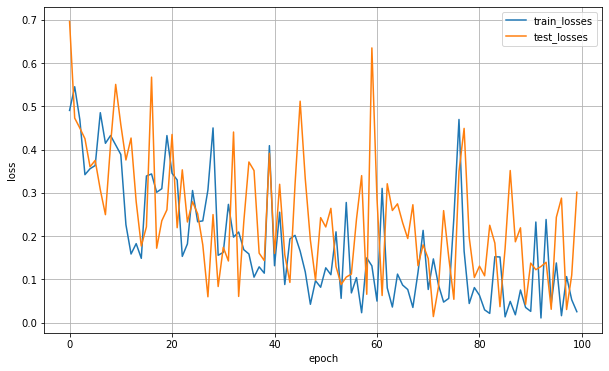

In [27]:
# Codeblock 26
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

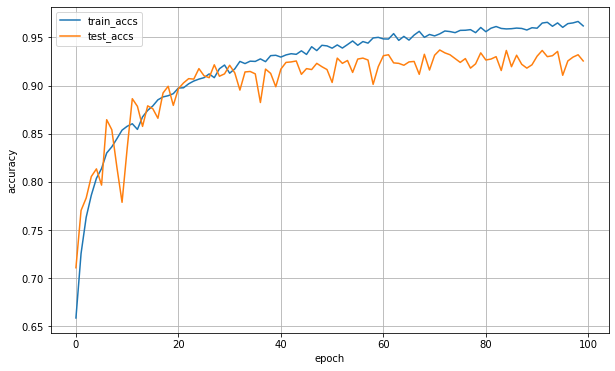

In [28]:
# Codeblock 27
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

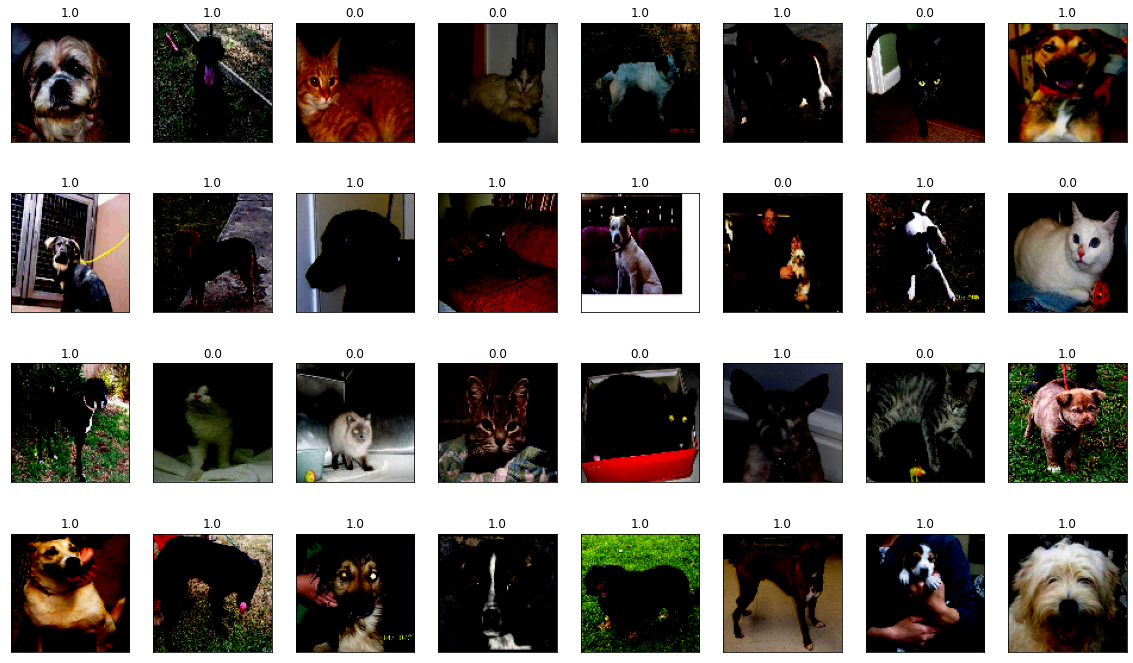

In [29]:
# Codeblock 28

# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)